In [1]:
import pandas as pd
import datetime as dt
import json
import numpy as np
import re
import requests
import tweepy

## 1. Data Gathering

### (1) arhive  file

In [3]:
#load archive csv file on hand

In [4]:
archive = pd.read_csv("twitter-archive-enhanced.csv")

In [5]:
archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


### (2) Image Prediction

In [6]:
# load prediction file programatically

In [7]:
tsv_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

In [8]:
# request data from url
r= requests.get(tsv_url)
r.status_code

200

In [9]:
with open(tsv_url.split('/')[-1] , mode= 'wb') as f :
    f.write(r.content)

In [10]:
pred = pd.read_csv(tsv_url.split('/')[-1] , sep='\t')
pred.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


### (3) Twitter API

In [11]:
consumer_key = '0sve2xmPKKK9skOmqs8iLfDqs'
consumer_secret = 'WutPqTLzkmYlb0ysDY2MqLukgay2dTRm9x7QSf987PnWGhUT0s'
access_token = '848649054-VSnxULkpm97OElFqBuxaYWMIBloaH0frUK0pqY8K'
access_secret = 'hyyfwZQeZtZMmJcn6lgi1tPOJs8BnhmedCuYUfg3dYi7c'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [12]:
# Tweepy status list 
tweet_ls = []
# Tweets list if the try get error
exception_ls = []
for t_id in archive['tweet_id']:   
    try:
        tweet_ls.append(api.get_status(t_id))
    except Exception as e:
        print(e , 'Error for' , t_id)
        exception_ls.append(t_id)

KeyboardInterrupt: 

In [ ]:
print(len(tweet_ls))
print(len(exception_ls))

In [ ]:
my_list_of_dicts = []
for each_json_tweet in tweet_ls:
    my_list_of_dicts.append(each_json_tweet._json)

In [ ]:
#identify information of interest from JSON dictionaries in txt file
#and put it in a dataframe called tweet JSON
my_demo_list = []
with open('tweet_json.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        tweet_id = each_dictionary['id']
        whole_tweet = each_dictionary['text']
        only_url = whole_tweet[whole_tweet.find('https'):]
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        whole_source = each_dictionary['source']
        only_device = whole_source[whole_source.find('rel="nofollow">') + 15:-4]
        source = only_device
        retweeted_status = each_dictionary['retweeted_status'] = each_dictionary.get('retweeted_status', 'Original tweet')
        if retweeted_status == 'Original tweet':
            url = only_url
        else:
            retweeted_status = 'This is a retweet'
            url = 'This is a retweet'

        my_demo_list.append({'tweet_id': str(tweet_id),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'url': url,
                             'source': source,
                             'retweeted_status': retweeted_status,
                            })
        tweet_json = pd.DataFrame(my_demo_list, columns = ['tweet_id', 'favorite_count','retweet_count'
                                                           ,'source', 
                                                           'retweeted_status', 'url'])

In [ ]:
tweet_json

___

# 2. Data Assessing

In [2]:
archive = pd.read_csv('archive.csv')
pred = pd.read_csv('pred.csv')
tweet_json = pd.read_csv('tweet_json.csv')

### Table 1) Twitter Archive

In [3]:
pd.set_option('display.max_colwidth', 200)

In [4]:
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [5]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [6]:
archive.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [7]:
archive.name.sample(5)

307       Rory
1380      None
363     Astrid
2139      None
360        Mia
Name: name, dtype: object

In [8]:
temp = archive[['doggo','floofer','pupper','puppo']]

In [9]:
(temp!='None').sum(axis=1).max()

2

In [10]:
(temp!='None').sum(axis=1)[(temp!='None').sum(axis=1)==2]

191     2
200     2
460     2
531     2
565     2
575     2
705     2
733     2
778     2
822     2
889     2
956     2
1063    2
1113    2
dtype: int64

In [11]:
archive.loc[191,:]

tweet_id                                                                                                                                                                  855851453814013952
in_reply_to_status_id                                                                                                                                                                    NaN
in_reply_to_user_id                                                                                                                                                                      NaN
timestamp                                                                                                                                                          2017-04-22 18:31:02 +0000
source                                                                                                    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
text                          Here's a puppo participat

In [12]:
stage = archive[['doggo','floofer','pupper','puppo']]

In [13]:
stage[((stage!='None').sum(axis=1))>1]

,doggo,floofer,pupper,puppo
191,doggo,None,None,puppo
200,doggo,floofer,None,None
460,doggo,None,pupper,None
531,doggo,None,pupper,None
565,doggo,None,pupper,None
575,doggo,None,pupper,None
705,doggo,None,pupper,None
733,doggo,None,pupper,None
778,doggo,None,pupper,None
822,doggo,None,pupper,None


###  < Quality >


- __There are some typo or mis-spelled values in name__

- __Retweet and replies tweet exist in this Dataframe__

- __Datatype of tweed_id is wrong__


* __*Dominator and nominator shouldn't be a problem. it's just way of delivering point of humor , not real ratio*__

###  < Tidness >


- __Source column have html code , not normal string object__

- __Some of expanded_urls columns have multiple urls__

- __Timestamp should be split into data and time__
- __Text column contains url information__
- __Stage column should newly created after combining splited columns(doggo,pupper...)__  
    (There are some tweets showing two dogs , so thier dog stage could have two values as well. )

### Table 2) Image Prediction

In [14]:
pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [15]:

pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [16]:
pred.dtypes

tweet_id      int64
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

In [17]:
pred.jpg_url.duplicated().sum()

66

###  < Quality >

- __Datatype of tweed_id is wrong__
- __p1,p2,p3 should be capitalized for consistency__  
- __Some tweets have same URL of JPG FILE__

___

### Table 3) tweet_json

In [18]:
tweet_json.head()

,tweet_id,favorite_count,retweet_count,source,retweeted_status,url
0,892420643555336193,36949,7877,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,31793,5848,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,891815181378084864,23954,3862,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
3,891689557279858688,40281,8047,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,38485,8708,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3


In [19]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 6 columns):
tweet_id            2333 non-null int64
favorite_count      2333 non-null int64
retweet_count       2333 non-null int64
source              2333 non-null object
retweeted_status    2333 non-null object
url                 2333 non-null object
dtypes: int64(3), object(3)
memory usage: 109.4+ KB


In [20]:
tweet_json.dtypes

tweet_id             int64
favorite_count       int64
retweet_count        int64
source              object
retweeted_status    object
url                 object
dtype: object

In [21]:
tweet_json.describe()

,tweet_id,favorite_count,retweet_count
count,2.333000e+03,2333.000000,2333.000000
mean,7.419279e+17,7708.318045,2774.561937
std,6.820607e+16,11965.897550,4696.743041
min,6.660209e+17,0.000000,1.000000
25%,6.782786e+17,1337.000000,558.000000
50%,7.184547e+17,3354.000000,1300.000000
75%,7.986654e+17,9464.000000,3224.000000
max,8.924206e+17,159711.000000,79716.000000


In [22]:
tweet_json.retweeted_status.value_counts()

Original tweet       2168
This is a retweet     165
Name: retweeted_status, dtype: int64

In [23]:
tweet_json.source.value_counts()

Twitter for iPhone     2199
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                10
Name: source, dtype: int64

In [24]:
tweet_json.tweet_id.duplicated().sum()

0

###  < Quality >

- __retweets should be deleted__


___

# 3. Data Cleasing

## 3-1 ) Archive  Data Frame

- #### Identify and exlude tweets that have a retweeted_status because the tweet is a retweet and therefore not original.

In [25]:
archive_clean = archive.copy()

In [26]:
archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [27]:
# retweet rows (not original tweets)
archive_clean[archive_clean.retweeted_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,http...",13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,"https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873",12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,http...",13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,"https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1",14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…",8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Terrance. He's being yelled at because he stapled the wrong stuff together. 11/10 hang in there Terrance https://t.co/i…,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397445533696/photo/1,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10 https://t.co/dJx4Gzc50G,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,"https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,h...",14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Coco. At first I thought she was a cloud but clouds don't bork with such passion. 12/10 would hug softly https

In [28]:
# delete these rows using drop method
archive_clean.drop(index =archive_clean[archive_clean.retweeted_status_id.notnull()].index , inplace = True )

In [29]:
# check if the tweets which of text start with 'RT' still exist
archive_clean[(archive_clean.text.apply(lambda x : x.split(' ')[0]) == 'RT')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1286,708400866336894977,NaN,NaN,2016-03-11 21:15:02 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",RT if you are as ready for summer as this pup is 12/10 https://t.co/xdNNEZdGJY,NaN,NaN,NaN,https://vine.co/v/iHFqnjKVbIQ,12,10,None,None,None,None,None
1860,675489971617296384,NaN,NaN,2015-12-12 01:38:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT until we find this dog. Clearly a cool dog (front leg relaxed out window). Looks to be a superb driver. 10/10 https://t.co/MnTrKaQ8Wn,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675489971617296384/photo/1,10,10,None,None,None,None,None


In [30]:
archive_clean[archive_clean.in_reply_to_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen",NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547188785154/photo/1,14,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610513747968/photo/1,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None


In [31]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

- #### Convert the 'timestamp' column to DateTime and split into date and time from archive df

In [32]:
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])

In [33]:
archive_clean['date'] = archive_clean['timestamp'].apply(lambda time: time.strftime('%Y-%m-%d'))
archive_clean['time'] = archive_clean['timestamp'].apply(lambda time: time.strftime('%H:%M'))

In [34]:
archive_clean['date'] = pd.to_datetime(archive_clean['date'])
archive_clean['time'] = pd.to_datetime(archive_clean['time']).dt.time

In [35]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
date                          

In [36]:
archive_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,date,time
2038,671550332464455680,6.715449e+17,4.196984e+09,2015-12-01 04:44:10,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After 22 minutes of careful deliberation this dog is being demoted to a 1/10. The longer you look at him the more terrifying he becomes,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None,2015-12-01,04:44:00
238,847116187444137987,NaN,NaN,2017-03-29 16:00:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Unbelievable... We. Only. Rate. Dogs. Please stop sending in other things like this Blossoming Flop Kangaroo. Thank you... 11/10 https://t.co/EeeErAbso0,NaN,NaN,NaN,https://twitter.com/dog_rates/status/847116187444137987/photo/1,11,10,None,None,None,None,None,2017-03-29,16:00:00
2092,670782429121134593,NaN,NaN,2015-11-29 01:52:48,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This dude slaps your girl's ass what do you do?\n5/10 https://t.co/6dioUL6gcP,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670782429121134593/photo/1,5,10,None,None,None,None,None,2015-11-29,01:52:00
1617,685169283572338688,NaN,NaN,2016-01-07 18:41:01,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Gerbald. He just found out he's adopted. Poor pupper. Snazzy tongue tho. 11/10 would hold close in time of need https://t.co/UfGkB9Wrud,NaN,NaN,NaN,https://twitter.com/dog_rates/status/685169283572338688/photo/1,11,10,Gerbald,None,None,pupper,None,2016-01-07,18:41:00
521,809920764300447744,NaN,NaN,2016-12-17 00:38:52,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Please only send in dogs. We only rate dogs, not seemingly heartbroken ewoks. Thank you... still 10/10 would console https://t.co/HIraYS1Bzo",NaN,NaN,NaN,https://twitter.com/dog_rates/status/809920764300447744/photo/1,10,10,None,None,None,None,None,2016-12-17,00:38:00


- #### Combine into dog stage columns from doggo,floofer,pupper,puppo

In [37]:
stages = archive_clean[['doggo','floofer','pupper','puppo']].reset_index(drop=True)

In [38]:
multi_values = stages[((stages!='None').sum(axis=1))>1].index

In [39]:
stages['dog_stage'] = stages[['doggo', 'floofer', 'pupper', 'puppo']].max(axis=1)

In [40]:
stages.loc[multi_values,'dog_stage'] = 'Multi_Stage'

In [41]:
archive_clean['dog_stage'] = stages.dog_stage.values

In [42]:
archive_clean['dog_stage'].value_counts()

None           1831
pupper          224
doggo            75
puppo            24
Multi_Stage      12
floofer           9
Name: dog_stage, dtype: int64

- #### remove unwanted columns from archive df

In [43]:
unwanted_columns =['timestamp','in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_timestamp','retweeted_status_user_id','expanded_urls','source','doggo','floofer','pupper','puppo']

In [44]:
archive_clean.drop(columns=unwanted_columns, inplace=True)

In [45]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id              2175 non-null int64
text                  2175 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
date                  2175 non-null datetime64[ns]
time                  2175 non-null object
dog_stage             2175 non-null object
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 152.9+ KB


- #### Conver tweet_id datatype as obeject from int64 as it's not numeric value but identification object

In [46]:
archive_clean.tweet_id = archive_clean.tweet_id.astype(str)

In [47]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id              2175 non-null object
text                  2175 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
date                  2175 non-null datetime64[ns]
time                  2175 non-null object
dog_stage             2175 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 152.9+ KB


## 3-2 ) Tweet Json Data Frame

- #### Identify and exlude tweets that retweeted stauts is 'This is a retweet' because the tweet is a retweet and therefore not original.

In [48]:
tweet_clean = tweet_json.copy()

In [49]:
tweet_clean[tweet_clean.retweeted_status=='This is a retweet']

,tweet_id,favorite_count,retweet_count,source,retweeted_status,url
31,886054160059072513,0,101,Twitter for iPhone,This is a retweet,This is a retweet
35,885311592912609280,0,17287,Twitter for iPhone,This is a retweet,This is a retweet
67,879130579576475649,0,6358,Twitter for iPhone,This is a retweet,This is a retweet
72,878404777348136964,0,1203,Twitter for iPhone,This is a retweet,This is a retweet
73,878316110768087041,0,6237,Twitter for iPhone,This is a retweet,This is a retweet
77,877611172832227328,0,74,Twitter for iPhone,This is a retweet,This is a retweet
90,874434818259525634,0,13696,Twitter for iPhone,This is a retweet,This is a retweet
95,873337748698140672,0,1499,Twitter for iPhone,This is a retweet,This is a retweet
105,871166179821445120,0,5404,Twitter for iPhone,This is a retweet,This is a retweet
119,868639477480148993,0,1975,Twitter for iPhone,This is a retweet,This is a retweet


In [50]:
tweet_clean.drop(index = tweet_clean[tweet_clean['retweeted_status']=='This is a retweet'].index , inplace=True)

In [51]:
tweet_clean[tweet_clean.retweeted_status=='This is a retweet']

,tweet_id,favorite_count,retweet_count,source,retweeted_status,url


- #### remove columns not necessary 

In [52]:
tweet_clean.drop(columns=['source','url','retweeted_status'], inplace=True)

In [53]:
tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2168 entries, 0 to 2332
Data columns (total 3 columns):
tweet_id          2168 non-null int64
favorite_count    2168 non-null int64
retweet_count     2168 non-null int64
dtypes: int64(3)
memory usage: 67.8 KB


- #### Conver tweet_id datatype as obeject from int64 as it's not numeric value but identification object

In [54]:
tweet_clean.tweet_id = tweet_clean.tweet_id.astype(str)

## 3-3 ) Prediction Dataframe

In [55]:
pred_clean = pred.copy()

- #### Convert tweet_id column to string value

In [56]:
pred_clean.tweet_id = pred_clean.tweet_id.astype(str)

In [57]:
pred_clean.dtypes

tweet_id     object
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

- #### Capitalized first letter of the dog breed for consistency

In [58]:
pred_clean[['p1','p2','p3']] = pred_clean[['p1','p2','p3']].apply(lambda x : x.str.title() , axis=1 )

In [59]:
pred_clean[['p1','p2','p3']].sample(5)

,p1,p2,p3
1444,Long-Horned_Beetle,Ox,Rhinoceros_Beetle
356,Toy_Poodle,Miniature_Poodle,Toilet_Tissue
1701,Saluki,Afghan_Hound,Golden_Retriever
20,Maltese_Dog,Toy_Poodle,Miniature_Poodle
1388,Toy_Poodle,Miniature_Poodle,Cocker_Spaniel


## 3-4 ) Merged Dataframe

### ->Merge 3 DF info combined one for tideness

In [60]:
df_merge = pd.merge(archive_clean, tweet_clean,on='tweet_id', how='inner')

In [61]:
df_merge = pd.merge(df_merge, pred_clean,on='tweet_id', how='inner')

In [62]:
df_merge

,tweet_id,text,rating_numerator,rating_denominator,name,date,time,dog_stage,favorite_count,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,2017-08-01,16:23:00,None,36949,7877,...,1,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False
1,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,10,Tilly,2017-08-01,00:17:00,None,31793,5848,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,2017-07-31,00:18:00,None,23954,3862,...,1,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
3,891689557279858688,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10,Darla,2017-07-30,15:58:00,None,40281,8047,...,1,Paper_Towel,0.170278,False,Labrador_Retriever,0.168086,True,Spatula,0.040836,False
4,891327558926688256,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12,10,Franklin,2017-07-29,16:00:00,None,38485,8708,...,2,Basset,0.555712,True,English_Springer,0.225770,True,German_Short-Haired_Pointer,0.175219,True
5,891087950875897856,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,13,10,None,2017-07-29,00:08:00,None,19350,2899,...,1,Chesapeake_Bay_Retriever,0.425595,True,Irish_Terrier,0.116317,True,Indian_Elephant,0.076902,False
6,890971913173991426,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,13,10,Jax,2017-07-28,16:27:00,None,11279,1915,...,1,Appenzeller,0.341703,True,Border_Collie,0.199287,True,Ice_Lolly,0.193548,False
7,890729181411237888,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,13,10,None,2017-07-28,00:22:00,None,62319,17591,...,2,Pomeranian,0.566142,True,Eskimo_Dog,0.178406,True,Pembroke,0.076507,True
8,890609185150312448,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,13,10,Zoey,2017-07-27,16:25:00,None,26625,3995,...,1,Irish_Terrier,0.487574,True,Irish_Setter,0.193054,True,Chesapeake_Bay_Retriever,0.118184,True
9,890240255349198849,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,14,10,Cassie,2017-07-26,15:59:00,doggo,30479,6848,...,1,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True


# 4. Saving

Saving cleaned dataframe info csv file

In [63]:
df_merge.to_csv('twitter_archive_master.csv: ', index= False, encoding='utf-8')

In [64]:
archive_clean.to_csv('archive_clean.csv', index= False, encoding='utf-8')
pred_clean.to_csv('pred_clean.csv', index= False, encoding='utf-8')
tweet_clean.to_csv('tweet_clean.csv', index= False, encoding='utf-8')


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

# 5. Analyzing, and Visualizing Data

### Taking a look cleaned df

In [65]:
df_merge.describe()

,rating_numerator,rating_denominator,favorite_count,retweet_count,img_num,p1_conf,p2_conf,p3_conf
count,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1.987000e+03,1.987000e+03
mean,12.280825,10.533971,8441.613991,2513.433820,1.203322,0.593317,1.344725e-01,6.037114e-02
std,41.570741,7.333532,12419.784423,4498.878688,0.561369,0.271959,1.005706e-01,5.091543e-02
min,0.000000,2.000000,73.000000,11.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,10.000000,10.000000,1814.000000,562.000000,1.000000,0.361531,5.409535e-02,1.624950e-02
50%,11.000000,10.000000,3801.000000,1213.000000,1.000000,0.587342,1.175080e-01,4.953060e-02
75%,12.000000,10.000000,10514.500000,2855.000000,1.000000,0.844583,1.950575e-01,9.180755e-02
max,1776.000000,170.000000,159711.000000,79716.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


In [66]:
df_merge.sample(5)

,tweet_id,text,rating_numerator,rating_denominator,name,date,time,dog_stage,favorite_count,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1305,683852578183077888,"Say hello to Tiger. He's a penbroke (little dog pun for ya, no need to applaud I know it was good) 10/10 good dog https://t.co/Yei0HzS3JN",10,10,Tiger,2016-01-04,03:28:00,None,1965,352,...,1,Toy_Poodle,0.551352,True,Teddy,0.180678,False,Miniature_Poodle,0.164095,True
1747,670444955656130560,This is Paull. He just stubbed his toe. 10/10 deep breaths Paull https://t.co/J5Mqn8VeYq,10,10,Paull,2015-11-28,03:31:00,None,6617,1945,...,1,English_Springer,0.403698,True,Brittany_Spaniel,0.347609,True,Welsh_Springer_Spaniel,0.137186,True
1523,675006312288268288,Say hello to Mollie. This pic was taken after she bet all her toys on Ronda Rousey. 10/10 hang in there pupper https://t.co/QMmAqA9VqO,10,10,Mollie,2015-12-10,17:37:00,pupper,979,224,...,1,Boxer,0.654697,True,Space_Heater,0.043389,False,Beagle,0.042848,True
623,763183847194451968,This is Clark. He collects teddy bears. It's absolutely h*ckin horrifying. 8/10 please stop this Clark https://t.co/EDMcwt86fU,8,10,Clark,2016-08-10,01:23:00,None,5545,1524,...,1,Miniature_Poodle,0.354674,True,Toy_Poodle,0.338642,True,Teddy,0.155828,False
522,782722598790725632,"This is Penny. She fought a bee and the bee won. 10/10 you're fine Penny, everything's fine https://t.co/zrMVdfFej6",10,10,Penny,2016-10-02,23:23:00,None,17916,5621,...,1,Irish_Setter,0.574557,True,Golden_Retriever,0.339251,True,Seat_Belt,0.046108,False


In [67]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 1986
Data columns (total 21 columns):
tweet_id              1987 non-null object
text                  1987 non-null object
rating_numerator      1987 non-null int64
rating_denominator    1987 non-null int64
name                  1987 non-null object
date                  1987 non-null datetime64[ns]
time                  1987 non-null object
dog_stage             1987 non-null object
favorite_count        1987 non-null int64
retweet_count         1987 non-null int64
jpg_url               1987 non-null object
img_num               1987 non-null int64
p1                    1987 non-null object
p1_conf               1987 non-null float64
p1_dog                1987 non-null bool
p2                    1987 non-null object
p2_conf               1987 non-null float64
p2_dog                1987 non-null bool
p3                    1987 non-null object
p3_conf               1987 non-null float64
p3_dog                1987 non-

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
plt.rcParams["figure.figsize"] = [12, 9]

### Number of tweet changed over time

In [70]:
monthly_tweets = df_merge.groupby(pd.Grouper(key = 'date', freq = "M")).count().reset_index()
monthly_tweets = monthly_tweets[['date', 'tweet_id']]
monthly_tweets.head()

,date,tweet_id
0,2015-11-30,296
1,2015-12-31,366
2,2016-01-31,169
3,2016-02-29,111
4,2016-03-31,120


Text(0,0.5,'Number of Tweets')

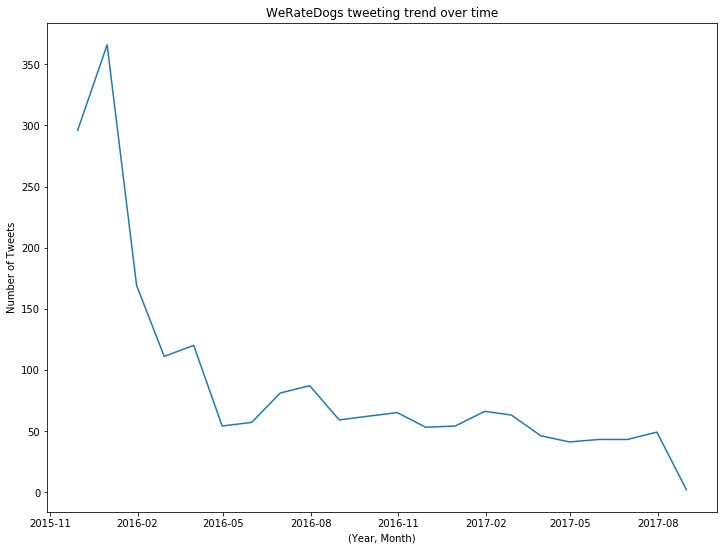

In [71]:
plt.plot(monthly_tweets.date, monthly_tweets.tweet_id)
plt.title('WeRateDogs tweeting trend over time')
plt.xlabel("(Year, Month)")
plt.ylabel("Number of Tweets")

__-> It has been decreased over time__

### Number of retweets and favorites Trend Over Time

In [72]:
montly_count = df_merge.groupby(pd.Grouper(key = 'date', freq = "M")).sum().reset_index()

In [73]:
montly_count = montly_count[['date', 'retweet_count','favorite_count']]

Text(0,0.5,'Number of Tweets')

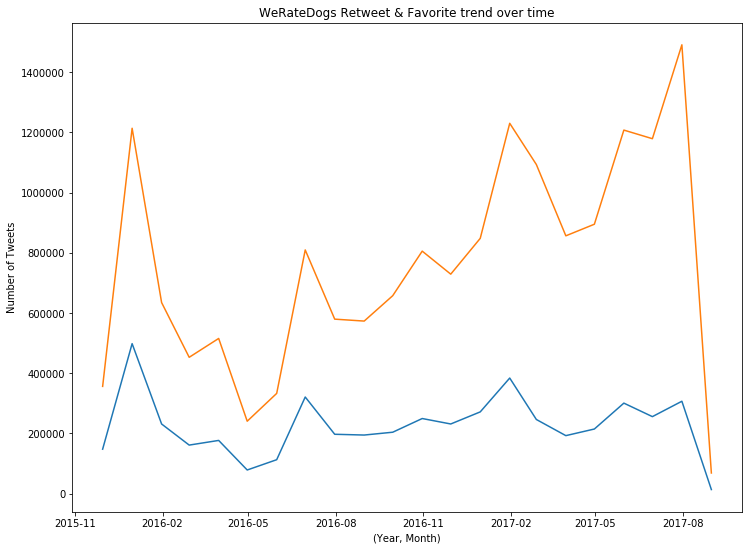

In [74]:
plt.plot(montly_count.date, montly_count.retweet_count)
plt.plot(montly_count.date, montly_count.favorite_count)
plt.title('WeRateDogs Retweet & Favorite trend over time')
plt.xlabel("(Year, Month)")
plt.ylabel("Number of Tweets")

__Despite  the number of tweets has been decreased, Retweets and Favorites seems like getting higher excecpt for some period__

__Two of grhaps' shapes are pretty similar to each other__

### Relationship between the number of retweet and favorive

In [75]:
count_df= df_merge[['favorite_count','retweet_count']]

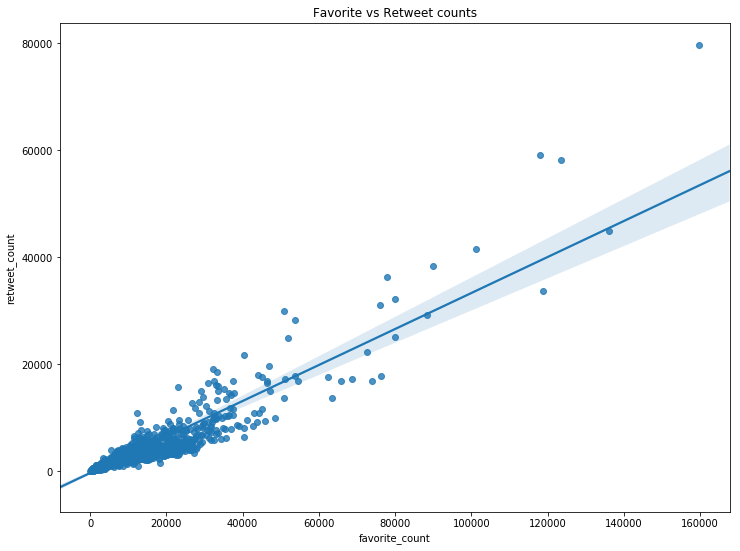

In [76]:
plt.title('Favorite vs Retweet counts')
sns.regplot(x=df_merge.favorite_count,y=df_merge.retweet_count)

__-> There is strong positive corelation. That is, The more tweets get favorite , the more tweets get retweeted__

### What is the most common dog stage

In [130]:
dog_pie_y = df_merge.dog_stage.value_counts()[1:]
explode = (0.1, 0.1, 0.1, 0.1, 0.1) 
colors = ['lightgreen', 'lightskyblue', 'lightskyblue','lightskyblue','lightskyblue']

([<matplotlib.patches.Wedge at 0x7f2fde351438>,
 [Text(-0.596428,1.04128,'pupper'),
  Text(0.129531,-1.19299,'doggo'),
  Text(0.992149,-0.675011,'puppo'),
  Text(1.16043,-0.305605,'Multi_Stage'),
  Text(1.19688,-0.0864475,'floofer')],
 [Text(-0.347917,0.607416,'66.56%'),
  Text(0.0755598,-0.69591,'20.33%'),
  Text(0.578754,-0.393756,'7.21%'),
  Text(0.676919,-0.17827,'3.61%'),
  Text(0.698181,-0.0504277,'2.30%')])

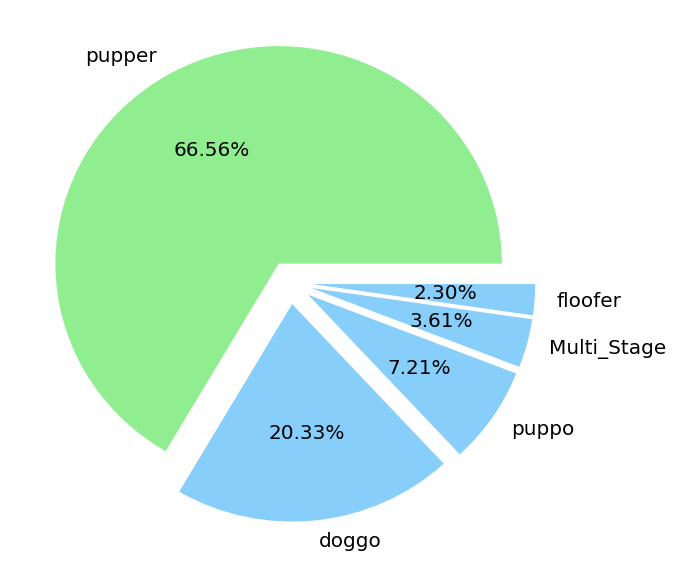

In [131]:
plt.figure(figsize=(10,10))
plt.pie(y,labels = dog_pie_y.index, textprops={'fontsize': 20},autopct='%1.2f%%', explode=explode ,colors= colors)

### Rank of stage

In [78]:
res = df_merge.groupby(['dog_stage'])['favorite_count'].mean()

In [79]:
res = res.sort_values()

In [80]:
idx = res.index.tolist()

In [81]:
idx.remove('None')

Text(0,0.5,'Average Number of Favorite')

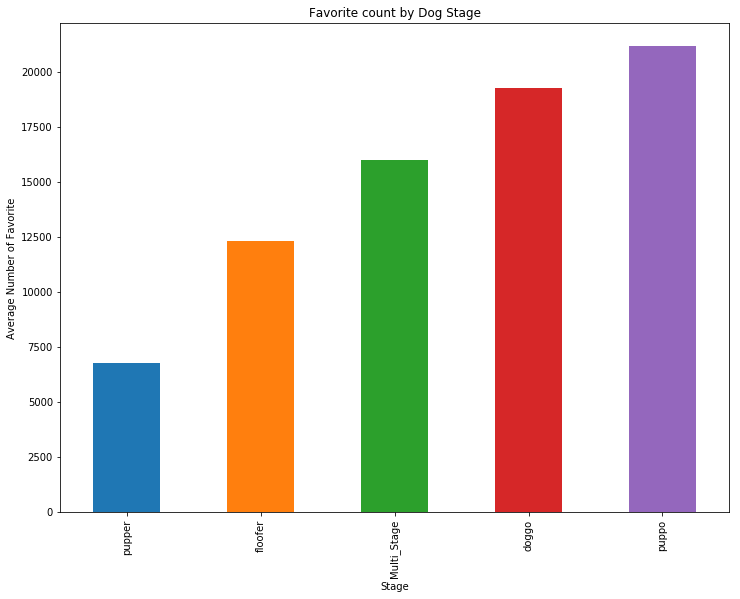

In [82]:
res[idx].plot(kind='bar')
plt.title('Favorite count by Dog Stage')
plt.xlabel("Stage")
plt.ylabel("Average Number of Favorite")

__-> puppo got most favorite__

### Probabilty Boxplot

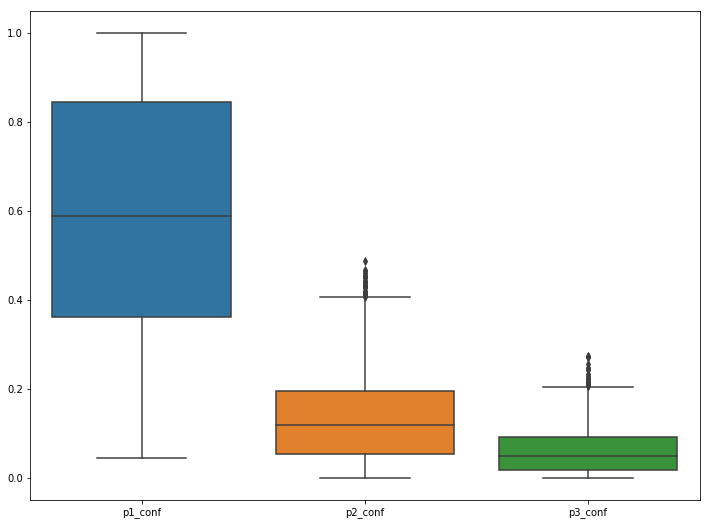

In [83]:
sns.boxplot(data =df_merge[['p1_conf','p2_conf','p3_conf']])

### Top 10 dogs breed most exsisting in tweets based on prediction

In [84]:
temp= df_merge.p1.value_counts()[:10]

In [85]:
temp.index

Index(['Golden_Retriever', 'Labrador_Retriever', 'Pembroke', 'Chihuahua',
       'Pug', 'Chow', 'Samoyed', 'Pomeranian', 'Toy_Poodle', 'Malamute'],
      dtype='object')

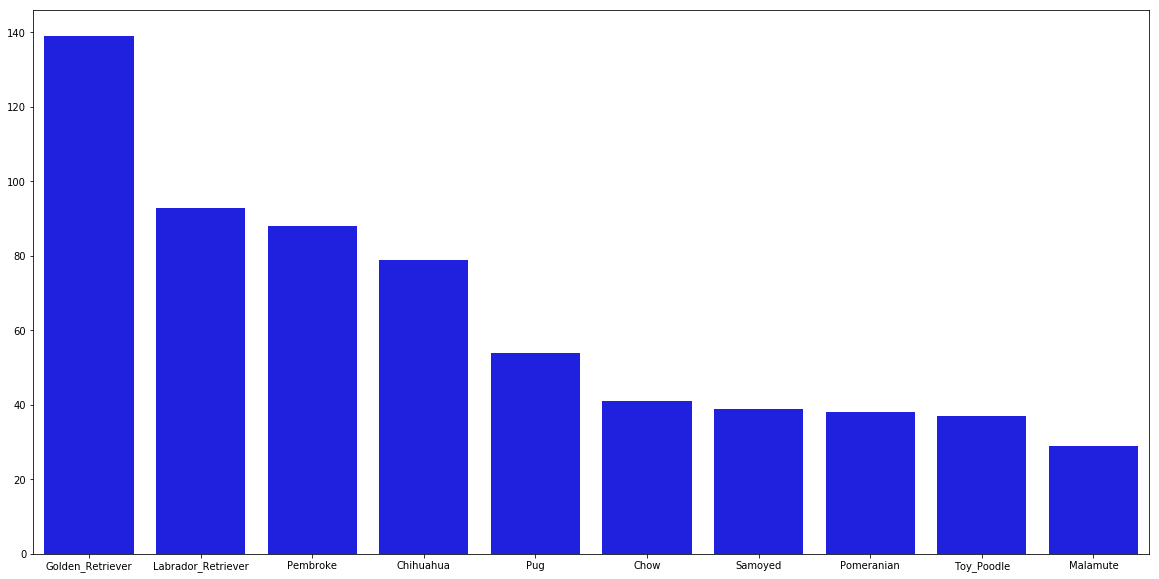

In [91]:
plt.figure(figsize= (20,10))
sns.barplot(temp.index.values, temp.values , color='b')

In [87]:
temp

Golden_Retriever      139
Labrador_Retriever     93
Pembroke               88
Chihuahua              79
Pug                    54
Chow                   41
Samoyed                39
Pomeranian             38
Toy_Poodle             37
Malamute               29
Name: p1, dtype: int64

In [88]:
temp.index.values

array(['Golden_Retriever', 'Labrador_Retriever', 'Pembroke', 'Chihuahua',
       'Pug', 'Chow', 'Samoyed', 'Pomeranian', 'Toy_Poodle', 'Malamute'], dtype=object)